# Working with coordinates in landsat scenes

## Load image

In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
dp = os.environ.get('pub_data')

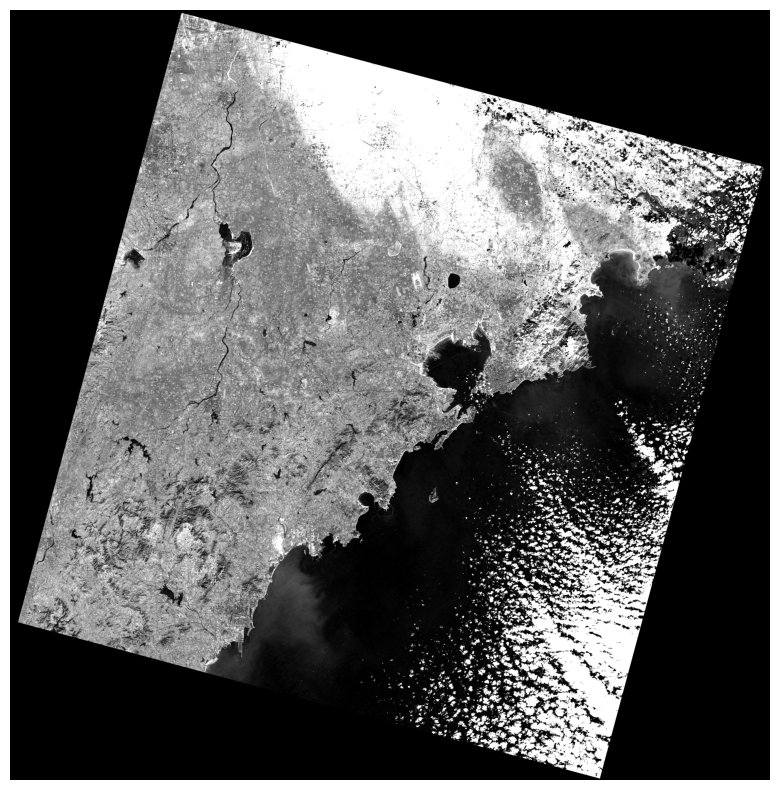

In [35]:
# Landsat scene ID
ID = 'LC09_L2SP_120035_20231221_20231223_02_T1'

# Load Red (B4) band
B4 = tiff.imread(dp + 'landsat_data/{}/{}_SR_B4.TIF'.format(ID, ID))

# Scale band
B4 = np.clip(B4*0.0000275-0.2, 0, 1)

# Clip to enhance contrast
B4 = np.clip(B4, 0, 0.2)/0.2

# Display grayscale image
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(B4, cmap='gray')
ax.set_axis_off()

### Using landsat metadata

In [36]:
import json

# Load metadata file
MTL = json.load(open(dp + 'landsat_data/{}/{}_MTL.json'.format(ID, ID)))
projection = MTL['LANDSAT_METADATA_FILE']['PROJECTION_ATTRIBUTES']
projection

{'MAP_PROJECTION': 'UTM',
 'DATUM': 'WGS84',
 'ELLIPSOID': 'WGS84',
 'UTM_ZONE': '51',
 'GRID_CELL_SIZE_REFLECTIVE': '30.00',
 'GRID_CELL_SIZE_THERMAL': '30.00',
 'REFLECTIVE_LINES': '7971',
 'REFLECTIVE_SAMPLES': '7861',
 'THERMAL_LINES': '7971',
 'THERMAL_SAMPLES': '7861',
 'ORIENTATION': 'NORTH_UP',
 'CORNER_UL_LAT_PRODUCT': '37.07512',
 'CORNER_UL_LON_PRODUCT': '118.64176',
 'CORNER_UR_LAT_PRODUCT': '37.14299',
 'CORNER_UR_LON_PRODUCT': '121.29191',
 'CORNER_LL_LAT_PRODUCT': '34.92549',
 'CORNER_LL_LON_PRODUCT': '118.75869',
 'CORNER_LR_LAT_PRODUCT': '34.98823',
 'CORNER_LR_LON_PRODUCT': '121.33788',
 'CORNER_UL_PROJECTION_X_PRODUCT': '112500.000',
 'CORNER_UL_PROJECTION_Y_PRODUCT': '4112100.000',
 'CORNER_UR_PROJECTION_X_PRODUCT': '348300.000',
 'CORNER_UR_PROJECTION_Y_PRODUCT': '4112100.000',
 'CORNER_LL_PROJECTION_X_PRODUCT': '112500.000',
 'CORNER_LL_PROJECTION_Y_PRODUCT': '3873000.000',
 'CORNER_LR_PROJECTION_X_PRODUCT': '348300.000',
 'CORNER_LR_PROJECTION_Y_PRODUCT': '387300

In [37]:
# Get UTM coordinates of upper left corner
ul = [float(projection['CORNER_UL_PROJECTION_X_PRODUCT']),
        float(projection['CORNER_UL_PROJECTION_Y_PRODUCT'])]

In [38]:
def coords_to_pixels(ul, utm, m=30):
   
    """ Convert UTM coordinates to pixel coordinates"""
    x = int((utm[0] - ul[0])/m)
    y = int((ul[1] - utm[1])/m)

    return x, y

In [39]:
import utm 

# GPS coordinates of Howth
lat=36.068153
long=120.442481

# Convert GPS to UTM coordinates
utmx,utmy,_,_ = utm.from_latlon(lat,long)
print(utmx,utmy)

# Convert UTM to pixel coordinates
x,y = coords_to_pixels(ul, [utmx,utmy])
print(x,y)

269671.7207717228 3994535.3416587417
5239 3918


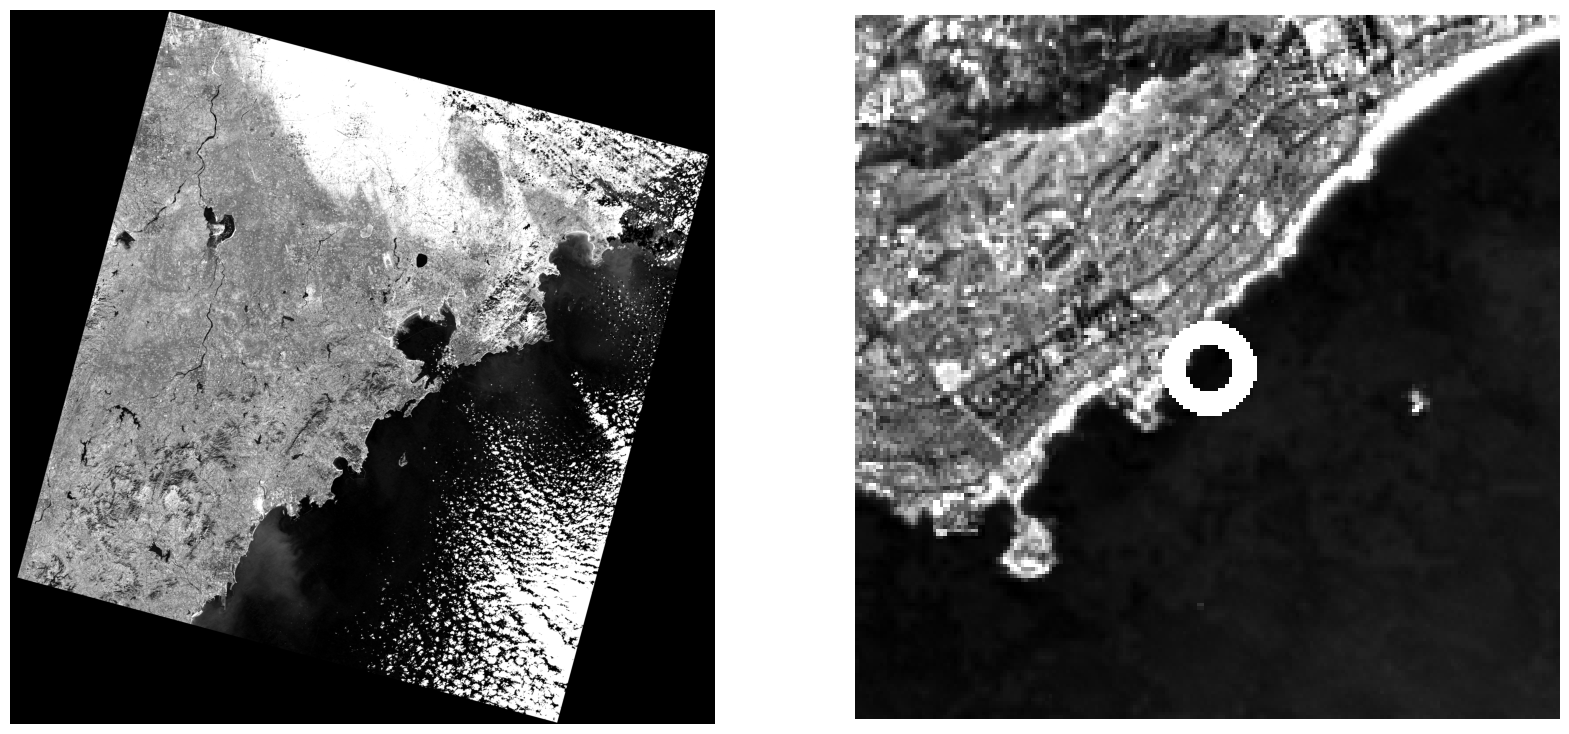

In [40]:
import cv2 

# Add circle to image at pixel coordinates
image = B4.copy()
image = cv2.circle(image, (int(x), int(y)), 10, 1,5)

# Crop image around pixel coordinates
h = 100
crop_image = image[y-h:y+h, x-h:x+h]

# Dsiplay image and crop
fig, ax = plt.subplots(1,2,figsize=(20, 20))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(crop_image, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()

## Using rasterio 

In [41]:
import rasterio as rio

# Open red channel with rasterio
B4 = rio.open(dp + 'landsat_data/{}/{}_SR_B4.TIF'.format(ID, ID))

# Display image map projection 
print(B4.crs)

EPSG:32651


In [42]:
# GPS coordinates of Howth
lat=36.068153
long=120.442481

# Get UTM coordinates
utmx,utmy,_,_ = utm.from_latlon(lat,long)

# Convert UTM to pixel coordinates
y,x = B4.index(utmx,utmy)
print(x,y)

5239 3919


In [2]:
from rasterio.warp import reproject, Resampling, calculate_default_transform

In [ ]:
dst_crs = "EPSG:4326"  # google maps CRS
filename = dp + 'landsat_data/{}/{}_SR_B4.TIF'.format(ID, ID)
new_filename = dp + 'landsat_data/{}/{}_SR_B4_EPSG4326.tif'.format(ID, ID)

# Open file
with rio.open(filename) as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  
        }
    )

    # write to disk
    with rio.open(new_filename, "w", **dst_kwargs) as dst:
        # reproject to new CRS
        reproject(
            source=rio.band(src, 1),
            destination=rio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
            

In [44]:
# Open red channel
B4 = rio.open(dp + 'landsat_data/{}/{}_SR_B4_EPSG4326.TIF'.format(ID, ID))
print(B4.crs)

EPSG:4326


In [45]:
# GPS coordinates of Howth
lat=36.068153
long=120.442481

# Convert UTM to pixel coordinates
y,x = B4.index(long,lat)
print(x,y)

5912 3529


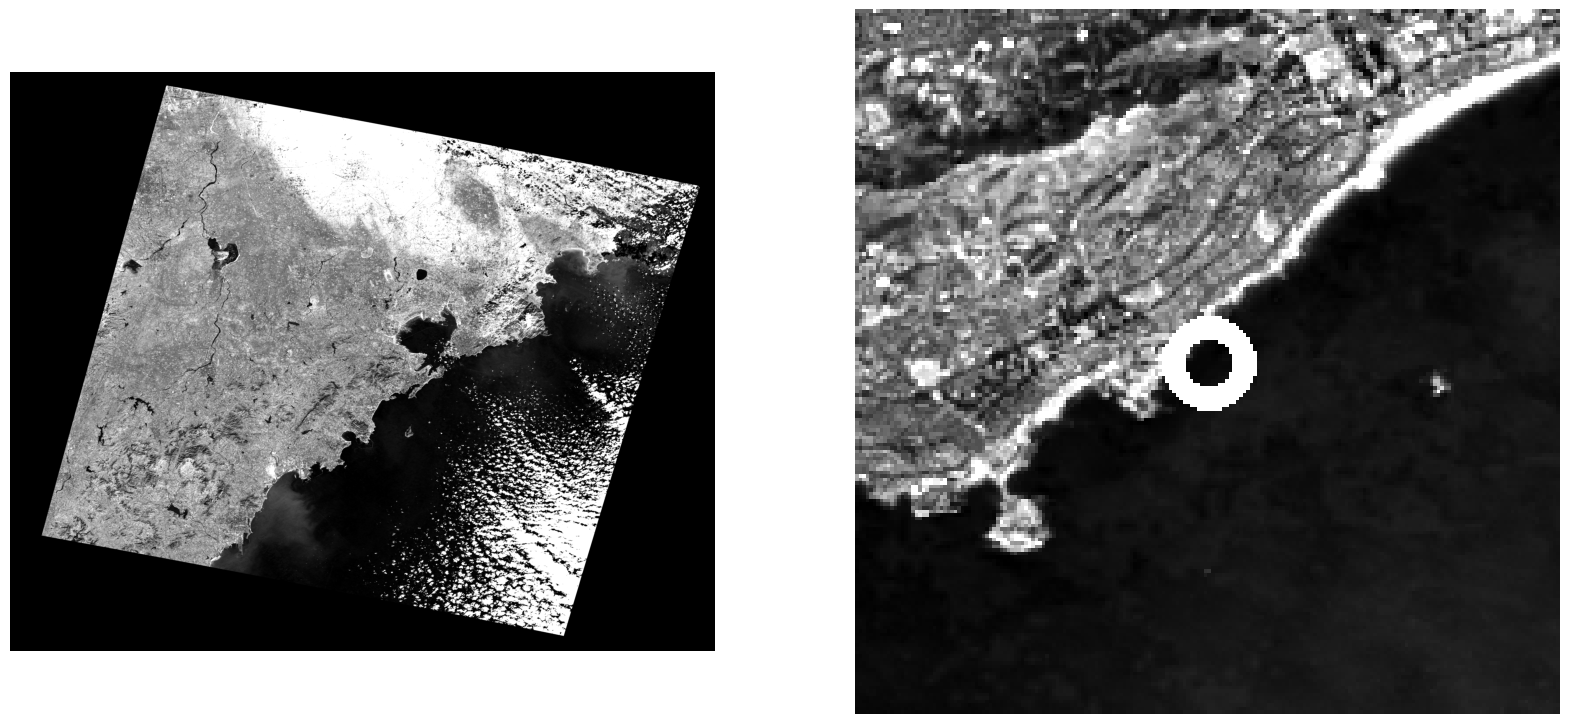

In [46]:
import cv2 

# Add circle to image at pixel coordinates
img= B4.read(1)
img = np.clip(img*0.0000275-0.2, 0, 1)
img = np.clip(img,0,0.2)/0.2
img = cv2.circle(img, (int(x), int(y)), 10,1,5)

# Crop image around pixel coordinates
h = 100
crop_img = img[y-h:y+h, x-h:x+h]

# Dsiplay image and crop
fig, ax = plt.subplots(1,2,figsize=(20, 20))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(crop_img, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()